## CNN for Text classification:

 **An end-to-end text classification pipeline**

`The aim of the notebook is to provide a general understanding of Convolutional Neural Network (CNN) and its implementation in Natural Language Processing (NLP) `

    1.Training text: It is the input text through which our supervised learning model is able to learn and predict the required class.
    2.Feature Vector: A feature vector is a vector that contains information describing the characteristics of the input data.
    3.Labels: These are the predefined categories/classes that our model will predict
    4.ML Algo: It is the algorithm through which our model is able to deal with text classification (In our case : CNN, RNN, CNN with Pretrained wordvec)
    5.Predictive Model: A model which is trained on the historical dataset which can perform label predictions.


In deep learning, a convolutional neural network **(CNN, or ConvNet)** is a class of deep neural networks, most commonly applied to analyzing visual imagery. For instance, CNN is used for applications such as image classification , facial recognition , object detection etc.


Most recently, however, **Convolutional** Neural Networks have also found prevalence in tackling problems associated with NLP tasks like Sentence Classification, Text Classification, Sentiment Analysis, Text Summarization, Machine Translation and Answer Relations.





In [1]:
!nvidia-smi

Tue Jun  2 13:07:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Checking tf version
import tensorflow as tf
print(tf.__version__)

2.1.0


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
#Importing req libraries
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

Using TensorFlow backend.


In [6]:
#Data gathering
df = pd.read_csv('/content/drive/My Drive/bbc-text.csv',delimiter=',')
print('No of instances :',len(df))

No of instances : 2225


In [7]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [8]:
#Total samples for each 
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

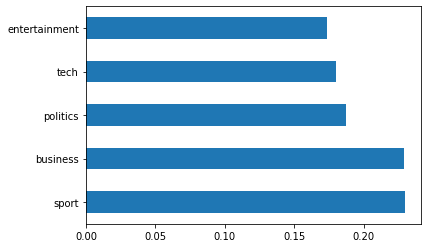

In [9]:
#Total samples for each (percentage)
df['category'].value_counts(normalize=True).plot.barh();

## EDA

In [0]:
df['length'] = df.text.apply(lambda x: len(x))

In [11]:
df.head()

,category,text,length
0,tech,tv future in the hands of viewers with home th...,4333
1,business,worldcom boss left books alone former worldc...,1842
2,sport,tigers wary of farrell gamble leicester say ...,1342
3,sport,yeading face newcastle in fa cup premiership s...,2176
4,entertainment,ocean s twelve raids box office ocean s twelve...,1579


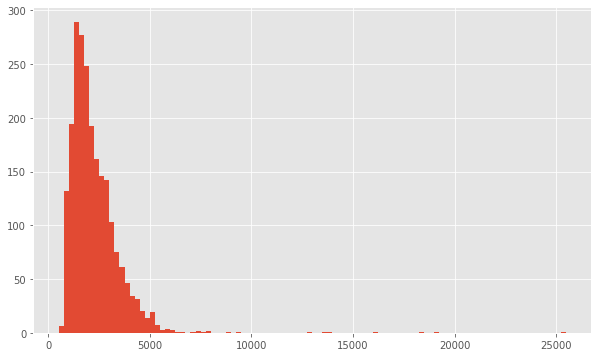

In [12]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(10,6))
#doc_lens = [len(d) for d in df['text']]
plt.hist(df['length'], bins = 100);

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


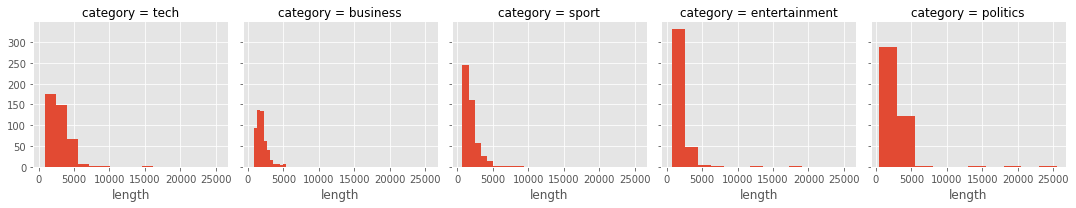

In [13]:
import seaborn as sns

g = sns.FacetGrid(df, col="category")
g = g.map(plt.hist, "length");

In [14]:
df.describe(percentiles=[.25,.5,.75,.9,.95,.99])

,length
count,2225.00000
mean,2262.93618
std,1364.10253
min,501.00000
25%,1446.00000
50%,1965.00000
75%,2802.00000
90%,3628.20000
95%,4286.80000
99%,5804.00000


AS we can see 95 percentage text length is less than 4200 words.

In [15]:
#Lets see for each category

cats = df.groupby('category')['length'].mean().round()

print('Average lenght of text for each category :')
cats

Average lenght of text for each category :


category
business         1985.0
entertainment    1926.0
politics         2682.0
sport            1895.0
tech             2974.0
Name: length, dtype: float64

Now we know politics and tech related articles are most likely to be lengthy,on average. Lets check it out:

In [16]:
df.groupby('category')['length'].agg(['mean','min','max']).round()

,mean,min,max
category,,,
business,1985.0,846,5406
entertainment,1926.0,823,19136
politics,2682.0,501,25483
sport,1895.0,719,9471
tech,2974.0,973,16158


Above dataframe confirmed my hypothesis that except business and sport article evrything seems to be lengthy one. Business related articles seems to be shortest one compared to others. However we shouldn't compare results like this,we have to analyse more in order to come to conclusion.

In [17]:
for i in df.category.unique():
  cats = df[df['category']==i]['length']
  dic = {i:list((np.quantile(cats,[.25,.5,.75,.90,.95,.99])))}
  print(pd.DataFrame(dic,index = ['25%','50%','75%','90%','95%','99%']))
  print()

       tech
25%  2045.0
50%  2636.0
75%  3749.0
90%  4678.0
95%  5101.0
99%  6280.0

     business
25%   1410.25
50%   1817.50
75%   2371.75
90%   3000.30
95%   3518.40
99%   5121.27

      sport
25%  1189.0
50%  1640.0
75%  2339.0
90%  3136.0
95%  3864.0
99%  5255.0

     entertainment
25%        1312.75
50%        1557.00
75%        2101.00
90%        3051.00
95%        3512.00
99%        6313.70

     politics
25%   1877.00
50%   2626.00
75%   3146.00
90%   3555.60
95%   4068.00
99%   5630.48



Hmmm... Every distinct category articles seems to have same length because some of the outliers i did interpret the outcome quite differently, reason is some outliers articles for tech and sports articles. We've come to know that every category articles most likely consist of less than 6000 words. Both boxplot and violinplot will show us the potential outliers for each category.

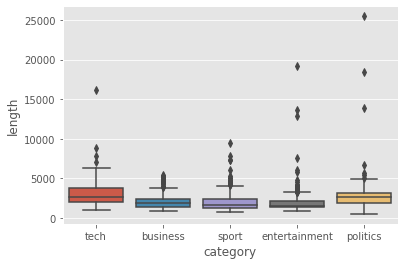

In [18]:
sns.boxplot(x=df['category'],y=df['length']);

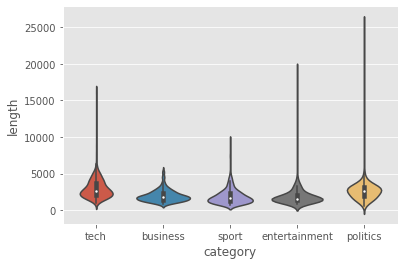

In [19]:
sns.violinplot(x=df['category'],y=df['length']);

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['text'], 10)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
df2

,unigram,count
0,said,7255
1,mr,3005
2,year,2309
3,people,2045
4,new,1978
5,time,1322
6,world,1201
7,government,1160
8,uk,1115
9,years,1003


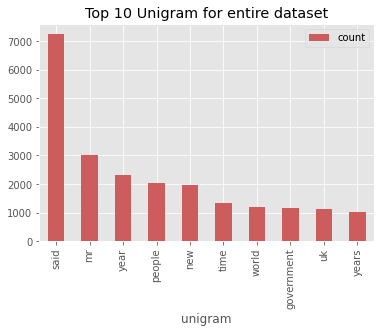

In [21]:
df2.plot.bar(x='unigram',y='count',color='indianred',title='Top 10 Unigram for entire dataset');

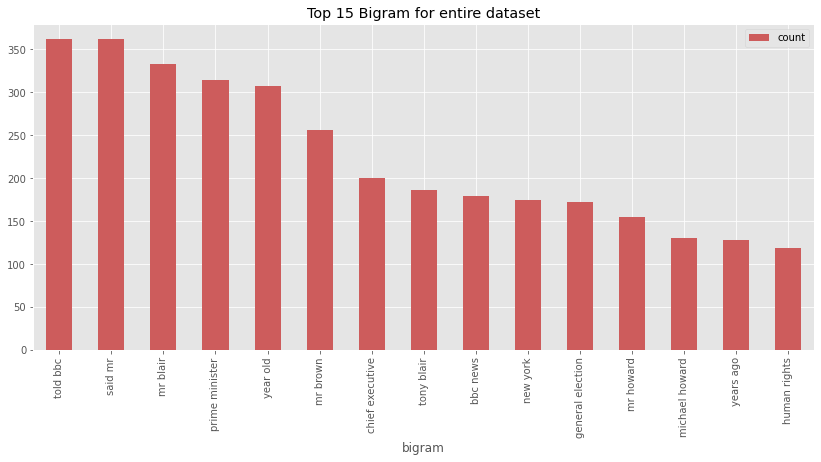

In [22]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['text'], 15)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
df3.plot.bar(x='bigram',y='count',color='indianred',title='Top 15 Bigram for entire dataset',figsize=(14,6));

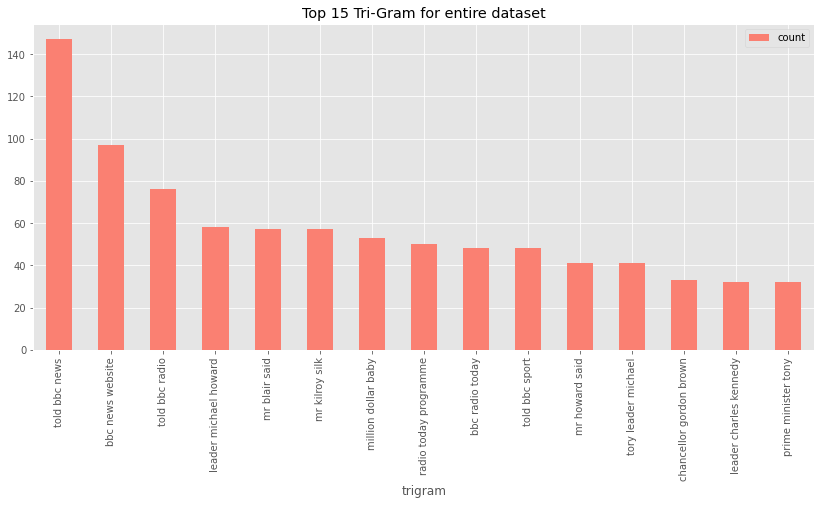

In [23]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(df['text'], 15)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
df4.plot.bar(x='trigram',y='count',color='salmon',title='Top 15 Tri-Gram for entire dataset',figsize=(14,6));

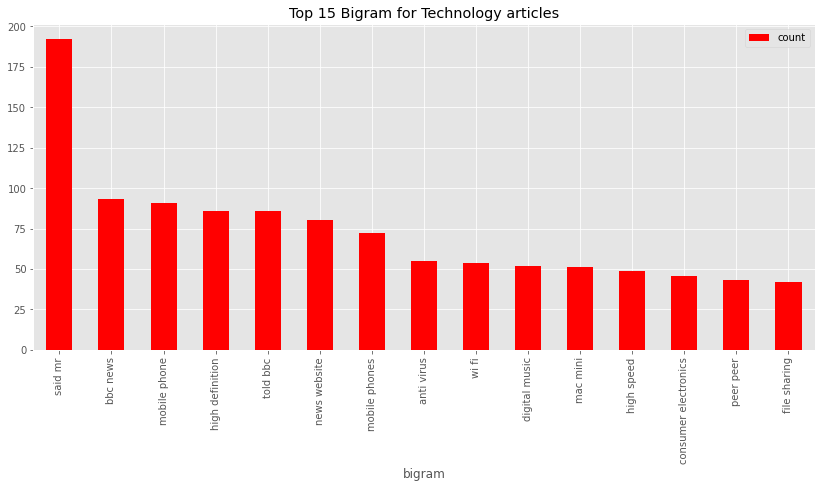

In [24]:
#Getting top words tech category
tech = df[df['category']=='tech']
tech_top =get_top_n_bigram(tech['text'],15)
tech_top = pd.DataFrame(tech_top, columns = ['bigram' , 'count'])
tech_top.plot.bar(x='bigram',y='count',color='r',title='Top 15 Bigram for Technology articles',figsize=(14,6));

Apart from first two top words in technology articles everything else makes much sense. Maybe we should remove top keywords such as said, mr,bbc etc.

#### **Dimensionality reduction with T-SNE**
   One very popular method for visualizing document similarity is to use t-distributed stochastic neighbor embedding.
   
   By decomposing high-dimensional document vectors into 2 dimensions using probability distributions from both the original dimensionality and the decomposed dimensionality, t-SNE is able to effectively cluster similar documents. **By decomposing to 2 or 3 dimensions**, the documents can be visualized with a scatter plot



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

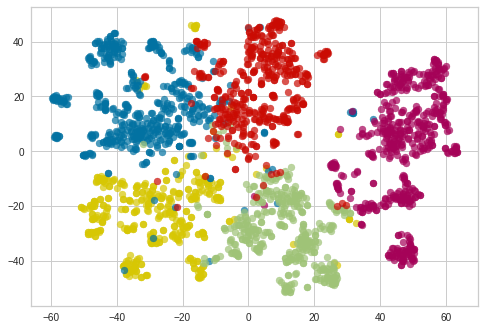

In [25]:
from yellowbrick.text import TSNEVisualizer

# Load the data and create document vectors
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(df['text'])
y = df.category

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y);

#### **UMAP Corpus Visualization**

**Uniform Manifold Approximation and Projection** (UMAP) is a nonlinear dimensionality reduction method that is well suited to embedding in two or three dimensions for visualization as a scatter plot. UMAP is a relatively new technique but is very effective for visualizing clusters or groups of data points and their relative proximities.

In [0]:
# from yellowbrick.text import UMAPVisualizer

# umap = UMAPVisualizer()
# umap.fit(X,y)

### **Word Clouds**

<Figure size 1008x576 with 0 Axes>

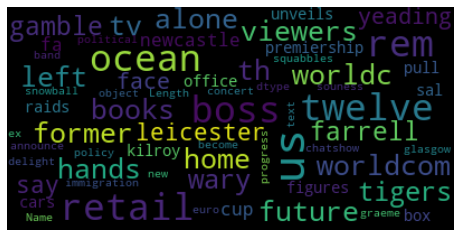

In [27]:
# lower max_font_size
from wordcloud import WordCloud

plt.figure(figsize=(14,8))
wordcloud = WordCloud(max_font_size=40).generate(str(df['text']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

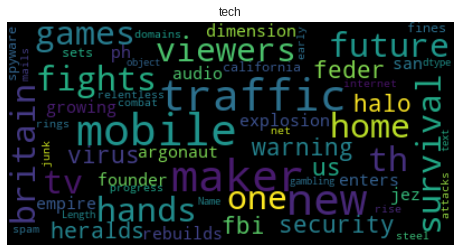

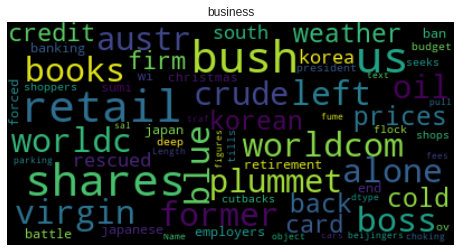

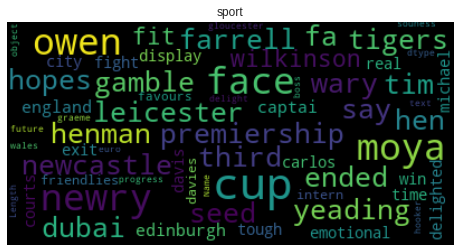

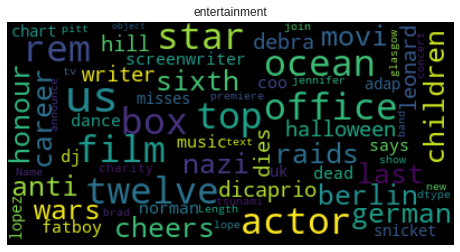

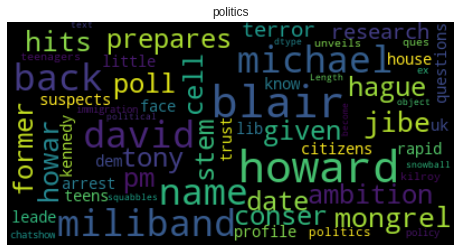

In [28]:
#Plotting wordclouds for each category:

for cats in df['category'].unique():
  wordcloud = WordCloud(max_font_size=40).generate(str(df[df['category']==cats]['text']))
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(cats)
  plt.show();

## Model building::

**CNNs** are generally used in computer vision, however they’ve recently been applied to various NLP tasks and the results were promising

### General architecture of a Convolutional Neural Network :

A convolutional neural network is composed of “convolutional” layers and “downsampling” or “subsampling” layers:

1.**Convolutional layers** comprise neurons that scan their input for patterns

2.**Downsampling layers** , or “pooling” layers are often placed after convolutional layers in a ConvNet, mainly to reduce the feature map dimensionality for computational efficiency, which can in turn improve actual performance.

3.Typically the two layers occur in an alternate order , but that’s not necessarily always the case.

<img src='https://miro.medium.com/max/1400/1*EPpYI-llkbtwHgfprtTJzw.png
'></a>

  `Just like images can be represented as an array of pixel values (float values), similarly we can represent the text as an array of vectors( each word mapped to a specific vector in a vector space composed of the entire vocabulary) that can be processed with the help of a CNN .When we are working with sequential data, like text, we work with one dimensional convolutions, but the idea and the application stays the same. We still want to pick up on patterns in the sequence which become more complex with each added convolutional layer.`

<img src='https://miro.medium.com/max/1400/1*04sklWe9Ok8W9zkq1LRO9w.png'></a>

In [0]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [30]:
from sklearn.model_selection import train_test_split

#Train and test set 
x_train,x_test,y_train,y_test = train_test_split(df['text'].values,df['category'].values,test_size=.25,random_state=100)

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

421
200
654
200
475
200


In [31]:
validation_sequences = tokenizer.texts_to_sequences(x_test)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

557
(557, 200)


In [0]:
# label_tokenizer = Tokenizer()
# label_tokenizer.fit_on_texts(labels)

# training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
# validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [33]:
from keras.models import Sequential
from keras.layers import Embedding,Conv1D,GlobalAveragePooling1D,Dense

model = Sequential()
#embedding layer
model.add(Embedding(vocab_size, embedding_dim,input_length=max_length))

#Conv filter
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           320000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 128)          41088     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 369,734
Trainable params: 369,734
Non-trainable params: 0
_________________________________________________________________


When we look at the summary of the model, the size of the input was 200 words, and a filter that is 5 words long will shave off 2 words from the front and back, leaving us with 196. The 128 filters that we specified will show up here as part of the convolutional layer.

In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [0]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
history = model.fit(train_padded, y_train, epochs=10, validation_data=(validation_padded, y_test), verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1668 samples, validate on 557 samples
Epoch 1/10
1668/1668 [==============================] - 2s 1ms/step - loss: 1.6252 - accuracy: 0.3112 - val_loss: 1.3339 - val_accuracy: 0.4183
Epoch 2/10
1668/1668 [==============================] - 0s 169us/step - loss: 0.7980 - accuracy: 0.7848 - val_loss: 0.4204 - val_accuracy: 0.9156
Epoch 3/10
1668/1668 [==============================] - 0s 162us/step - loss: 0.1907 - accuracy: 0.9664 - val_loss: 0.2354 - val_accuracy: 0.9390
Epoch 4/10
1668/1668 [==============================] - 0s 138us/step - loss: 0.0636 - accuracy: 0.9910 - val_loss: 0.1780 - val_accuracy: 0.9479
Epoch 5/10
1668/1668 [==============================] - 0s 147us/step - loss: 0.0251 - accuracy: 0.9976 - val_loss: 0.1757 - val_accuracy: 0.9497
Epoch 6/10
1668/1668 [==============================] - 0s 149us/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.9515
Epoch 7/10
1668/1668 [==============================] - 0s 145us/step - loss: 0

Our accuracy does even better than before with 100% on training and around 97% on validation. The validation loss did not increase. 

As we have a super simple network here, it's not surprising, and it will take some experimentation with different combinations of convolutional layers to improve on this.

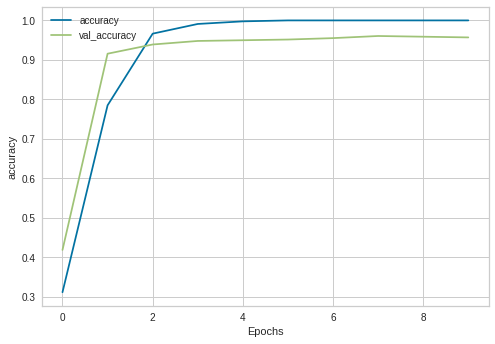

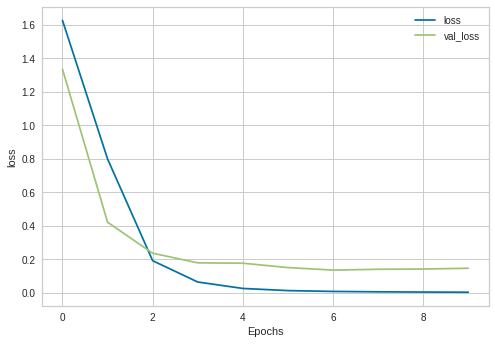

In [37]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Amazing!!! Our model did a great job. However we could have done some hyper params tuning such as dropout,earlystopping etc..

## Model Evualation:

In [38]:
y_pred = model.predict_classes(validation_padded)

from sklearn.metrics import accuracy_score

#Accuracy comparison
print(f"Test accuracy :{accuracy_score(y_test,y_pred)}")
print(f"Train accuracy :{accuracy_score(y_train,model.predict_classes(train_padded))}")

Test accuracy :0.9569120287253142
Train accuracy :1.0


OOpps!! Our model has overfitted on test data. we could do tune some params in order to balance the bias-variance issue.

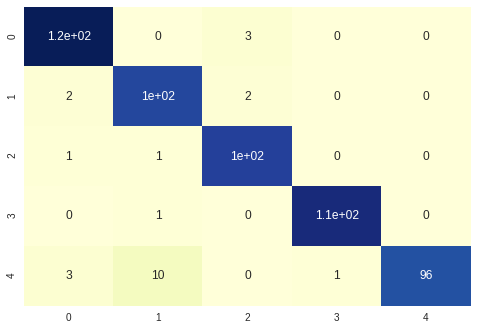

In [39]:
from sklearn.metrics import classification_report,confusion_matrix

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,cbar=False,cmap='YlGnBu',annot=True);

In [40]:
print(f"{classification_report(y_test,y_pred,target_names=df['category'].unique())} ")

               precision    recall  f1-score   support

         tech       0.95      0.98      0.96       125
     business       0.89      0.96      0.93       104
        sport       0.95      0.98      0.97       104
entertainment       0.99      0.99      0.99       114
     politics       1.00      0.87      0.93       110

     accuracy                           0.96       557
    macro avg       0.96      0.96      0.96       557
 weighted avg       0.96      0.96      0.96       557
 


In [41]:
txt = ["A WeWork shareholder has taken the company to court over the near-$1.7bn (£1.3bn) leaving package approved for ousted co-founder Adam Neumann."]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment']
print(pred, labels[np.argmax(pred)])

[[2.2725414e-02 6.2628562e-05 1.5656859e-02 9.6155512e-01 9.3133838e-09
  9.9045572e-09]] tech


### Closing Remarks:
  
  1. I did't apply any filters such as normalizing text,misspelling correction,removing unwanted characters etc. that will definitly boost model performance drastically.

  2. I've used created embedding vectors from scratch, however we could have loaded pre-trained wordvec could have positive effect on outcomes.

  3.This bbc dataset only has less than 2300 smaples.

I'll upload more notebooks where i cover lstm based model,Glove models etc.